In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pathlib

In [ ]:
# Set up the data directory
local_directory = "D:/p3 dataset/skin_cancer_segmented"
data_directory = pathlib.Path(local_directory)

if not data_directory.exists():
    raise FileNotFoundError(f"The directory {local_directory} does not exist.")

image_count = len(list(data_directory.glob('*/*.jpg')))
print(f"Number of images found: {image_count}")

class_names = sorted([item.name for item in data_directory.glob('*') if item.is_dir()])
print(f"Classes found: {class_names}")


Number of images found: 10015
Classes found: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


In [ ]:
# Define image size and batch size
img_height, img_width = 64, 64
batch_size = 16

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [ ]:
# Validation data should only be rescaled
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [ ]:
# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 9017 images belonging to 7 classes.


In [ ]:
# Flow validation images in batches using valid_datagen generator
valid_generator = valid_datagen.flow_from_directory(
    data_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 998 images belonging to 7 classes.


In [ ]:
# Set up the VGG16 model
vgg16 = VGG16(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg16.output)
output = Dense(len(class_names), activation='softmax')(x)

In [ ]:
model = Model(inputs=vgg16.input, outputs=output)

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall','f1_score']
)

In [ ]:
# View the model structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,729,031 (56.19 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Fit the model
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50
)

Epoch 1/50


C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


564/564 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.7736 - f1_score: 0.5587 - loss: 0.6015 - precision: 0.8334 - recall: 0.7171 - val_accuracy: 0.7595 - val_f1_score: 0.4233 - val_loss: 0.7155 - val_precision: 0.8259 - val_recall: 0.7275
Epoch 2/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 51s 90ms/step - accuracy: 0.7744 - f1_score: 0.5667 - loss: 0.6031 - precision: 0.8319 - recall: 0.7221 - val_accuracy: 0.7655 - val_f1_score: 0.4716 - val_loss: 0.7167 - val_precision: 0.8245 - val_recall: 0.7204
Epoch 3/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - accuracy: 0.7766 - f1_score: 0.5490 - loss: 0.6038 - precision: 0.8357 - recall: 0.7222 - val_accuracy: 0.7595 - val_f1_score: 0.5108 - val_loss: 0.7207 - val_precision: 0.8119 - val_recall: 0.7094
Epoch 4/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.7724 - f1_score: 0.5889 - loss: 0.5995 - precision: 0.8258 - recall: 0.7176 - val_accuracy: 0.7445 - val_f1_score: 0.4537 - val_loss: 0.7856 - val_precision: 0.7940 - val_recall: 0.

# METRICS

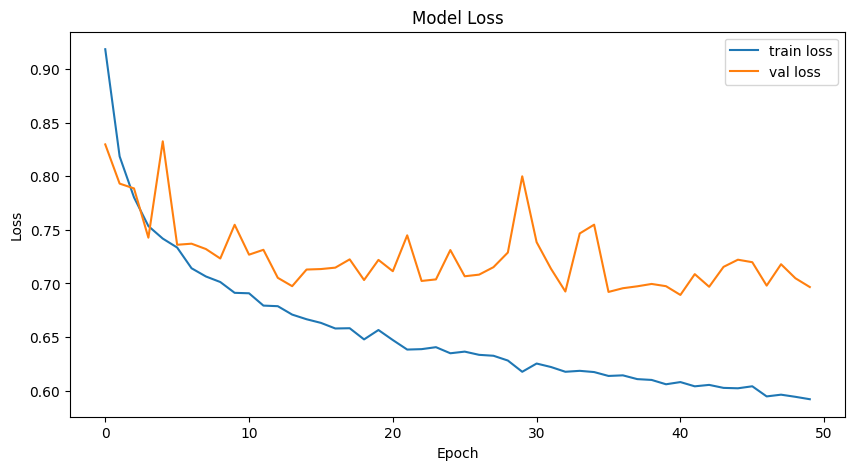

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LossVal_loss.png')


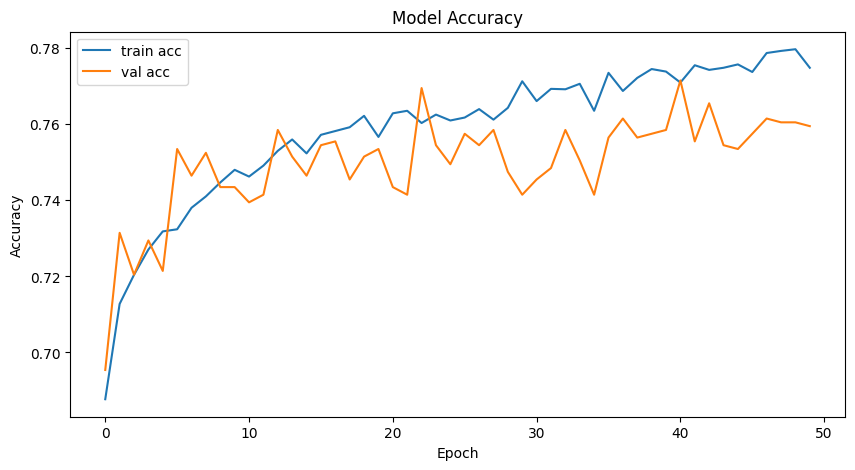

In [ ]:
# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('AccVal_acc.png')


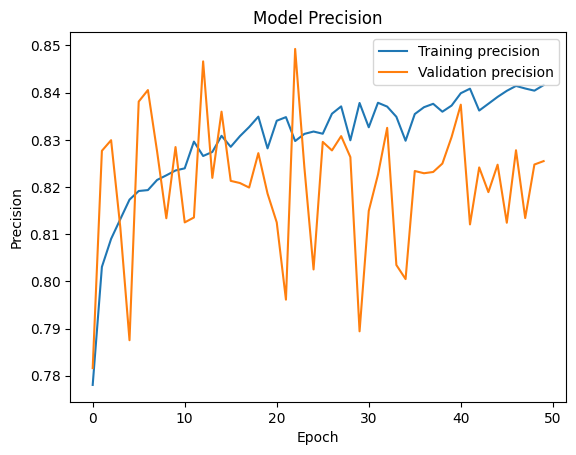

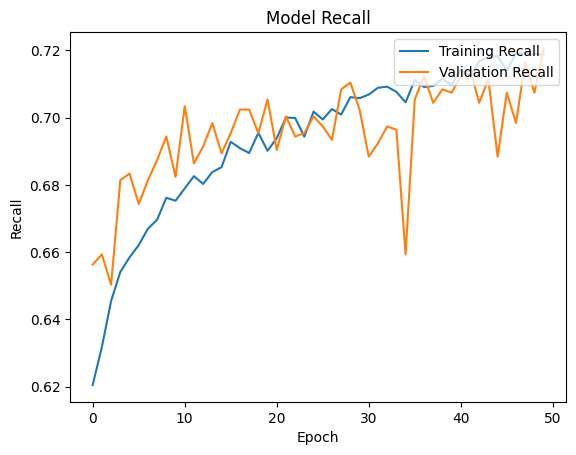

In [ ]:
plt.plot(r.history['precision'], label='Training precision')
plt.plot(r.history['val_precision'], label='Validation precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

plt.plot(r.history['recall'], label='Training Recall')
plt.plot(r.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

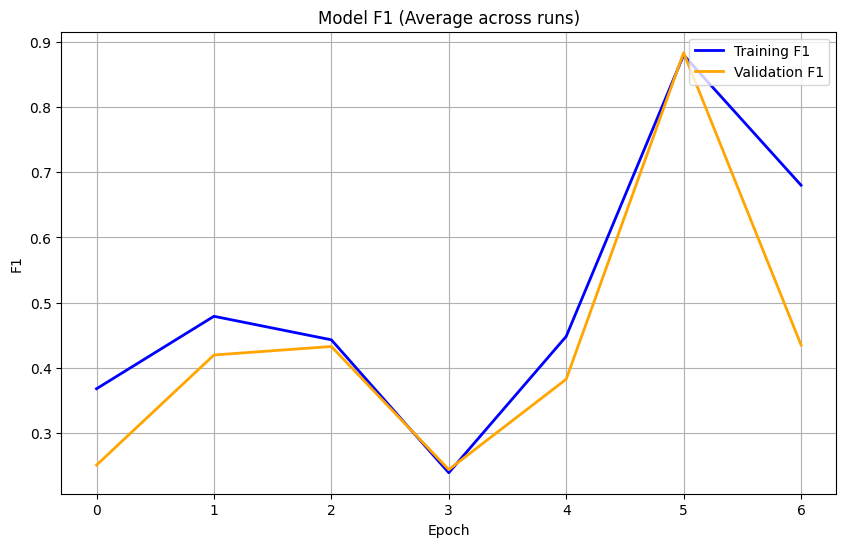

In [ ]:
plt.figure(figsize=(10, 6))
plt.clf()  # Clear the current figure

# Assuming r.history contains multiple runs
import numpy as np

# Calculate mean F1 scores across all runs
train_f1_mean = np.mean(r.history['f1_score'], axis=0)  # axis=0 for mean across runs
val_f1_mean = np.mean(r.history['val_f1_score'], axis=0)

# Optional: calculate standard deviation for error bands
train_f1_std = np.std(r.history['f1_score'], axis=0)
val_f1_std = np.std(r.history['val_f1_score'], axis=0)

# Plot mean lines
plt.plot(train_f1_mean, label='Training F1', color='blue', linewidth=2)
plt.plot(val_f1_mean, label='Validation F1', color='orange', linewidth=2)



plt.title('Model F1 (Average across runs)')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

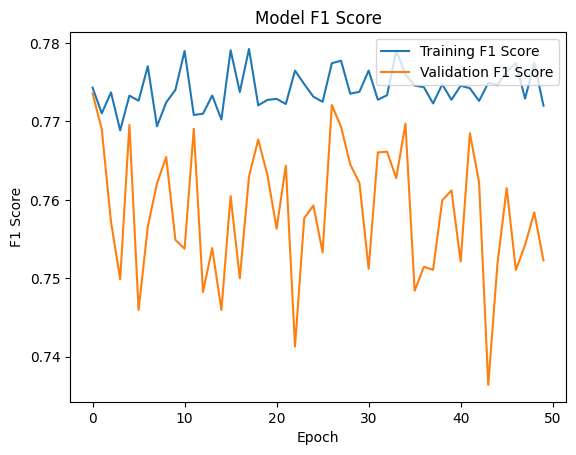

In [ ]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# Calculate F1 score using precision and recall from history
def calculate_f1_score(precision, recall):
   return 2 * (precision * recall) / (precision + recall)


# Extract precision and recall values
precision = r.history['precision']
recall = r.history['recall']
val_precision = r.history['val_precision']
val_recall = r.history['val_recall']


# Calculate F1 scores for training and validation
f1_scores = [calculate_f1_score(p, r) for p, r in zip(precision, recall)]
val_f1_scores = [calculate_f1_score(p, r) for p, r in zip(val_precision, val_recall)]


# Plot the F1 score graph
plt.plot(f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()



# CONFUSION MATRIX

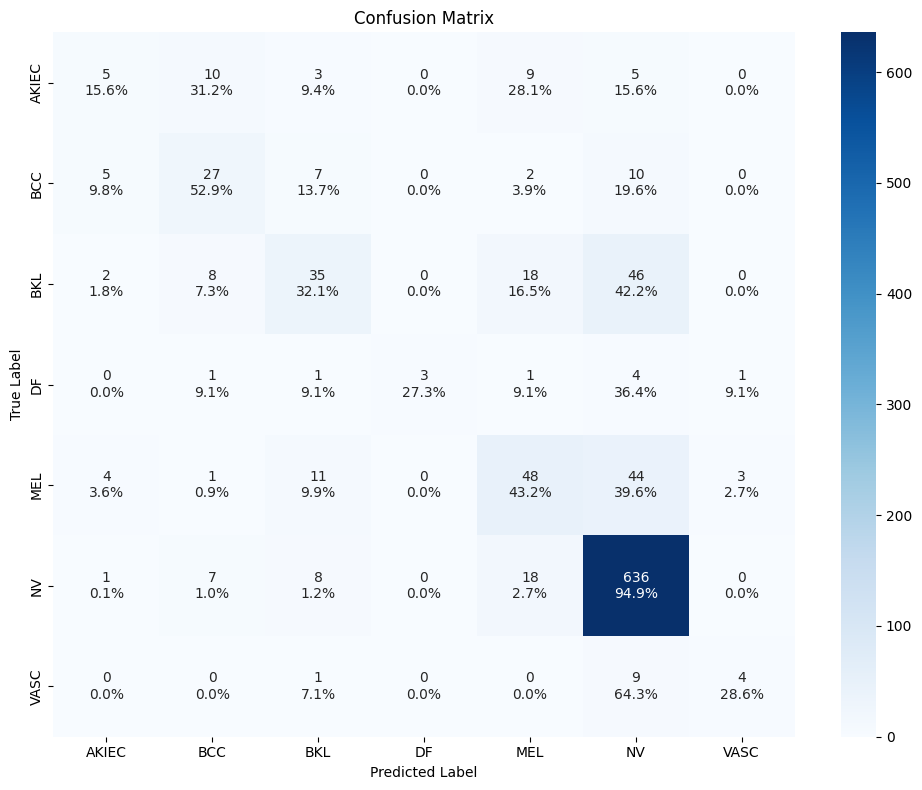


Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.29      0.16      0.20        32
         BCC       0.50      0.53      0.51        51
         BKL       0.53      0.32      0.40       109
          DF       1.00      0.27      0.43        11
         MEL       0.50      0.43      0.46       111
          NV       0.84      0.95      0.89       670
        VASC       0.50      0.29      0.36        14

    accuracy                           0.76       998
   macro avg       0.60      0.42      0.47       998
weighted avg       0.73      0.76      0.74       998



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get class names from the generator
class_names = list(valid_generator.class_indices.keys())

def prepare_predictions(model, dataset):
    # Get predictions for all batches
    y_true = []
    y_pred = []

    # Reset dataset
    dataset.reset()

    # Predict on batches
    for i in range(len(dataset)):
        x, y = dataset[i]
        predictions = model.predict(x, verbose=0)

        # Convert one-hot encoded labels back to class indices
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))

    return np.array(y_true), np.array(y_pred)

# Get predictions
y_true, y_pred = prepare_predictions(model, valid_generator)

# Create and plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap with both numbers and percentages
sns.heatmap(cm, annot=np.array([[f'{int(x)}\n{y:.1f}%'
                                for x, y in zip(row_a, row_p)]
                               for row_a, row_p in zip(cm, cm_percent)]),
            fmt='', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
#import torch
#gpu_indx = 0
#device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')
#plot_confusion_matrix(model, valid_generator, device, class_names=['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])


In [ ]:

# Save model weights
model.save_weights('D:/20201033/final/vgg/vgg_model_weights.weights.h5')

# Save entire model (architecture + weights + optimizer state)
model.save('D:/20201033/final/vgg/vgg_complete_model.keras')


# To later load and continue training:
"""
# Load history
with open('model_history.json', 'r') as f:
    previous_history = json.load(f)

# Load complete model
from tensorflow.keras.models import load_model
model = load_model('complete_model.h5')

# OR load just weights into a new model
model.load_weights('model_weights.h5')
"""

"\n# Load history\nwith open('model_history.json', 'r') as f:\n    previous_history = json.load(f)\n\n# Load complete model\nfrom tensorflow.keras.models import load_model\nmodel = load_model('complete_model.h5')\n\n# OR load just weights into a new model\nmodel.load_weights('model_weights.h5')\n"

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model (architecture + weights + optimizer)
model = load_model('D:/20201033/final/vgg/vgg_complete_model.keras')

print("Complete model loaded successfully!")


Complete model loaded successfully!


C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import json

# Load the history from the JSON file
with open('D:/20201033/final/vgg/vgg_model_history.json', 'r') as f:
    history = json.load(f)

# Now you can access precision, recall, and calculate F1 scores
precision = history['precision']
recall = history['recall']
val_precision = history['val_precision']
val_recall = history['val_recall']

# Calculate F1 scores for training and validation
f1_scores = [calculate_f1_score(p, r) for p, r in zip(precision, recall)]
val_f1_scores = [calculate_f1_score(p, r) for p, r in zip(val_precision, val_recall)]

# Plot the F1 score graph
plt.plot(f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


JSONDecodeError: Expecting value: line 1 column 1024 (char 1023)

# APPLYING GRADCAM

In [ ]:
pip install grad-cam

In [ ]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms import functional as F

# height = width = image_size/patch_size = 64/16
# Adjust reshape function for your ViT
def reshape_transform(tensor, height=4, width=4):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Define target layers for Grad-CAM
target_layers = [model.blocks[-1].norm1]  # Adjust based on your model architecture
targets = [ClassifierOutputTarget(5)]

# Load and preprocess an input image
# Replace with a valid path to your image or upload an image in Colab
image_path = 'D:/p3 dataset/skin_cancer_segmented/NV/ISIC_0024306.jpg'  # Example path
rgb_img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
rgb_img = cv2.resize(rgb_img, (64, 64))  # Resize to your model's expected input size
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

model.eval()
pred = model(input_tensor)
print("Predicted class:", torch.argmax(pred).item())

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# Initialize Grad-CAM++
cam_plusplus = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets = targets)
grayscale_cam = grayscale_cam[0, :]
# Generate Grad-CAM++
grayscale_cam_plusplus = cam_plusplus(input_tensor=input_tensor, targets=targets)
grayscale_cam_plusplus = grayscale_cam_plusplus[0,:]

# Overlay CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
# Overlay Grad-CAM++ on the image
visualization_plusplus = show_cam_on_image(rgb_img, grayscale_cam_plusplus, use_rgb=True)


# Plot original image, Grad-CAM, and Grad-CAM++ visualizations
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM visualization
plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')

# Grad-CAM++ visualization
plt.subplot(1, 3, 3)
plt.imshow(visualization_plusplus)
plt.title("Grad-CAM++ Visualization")
plt.axis('off')

plt.tight_layout()
plt.show()

AttributeError: 'Functional' object has no attribute 'blocks'

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

# y_pred = model.predict(test_set)
# y_pred